In [12]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE2_30.pth'


In [13]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [14]:
# Extract hidden states(TSNE2)/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=2, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [15]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [16]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 8/8 [13:08<00:00, 98.51s/it] 


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 8/8 [17:07<00:00, 128.43s/it]


Hidden states reduced to 2 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


In [19]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=770 and hidden_dim=256


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:   2%|▏         | 10/500 [00:00<00:11, 43.09it/s]

Epoch 10/500, Loss: 0.5735
Test Accuracy at Epoch 10: 50.00%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.61      0.55       194
non_infringement       0.49      0.39      0.43       186

        accuracy                           0.50       380
       macro avg       0.50      0.50      0.49       380
    weighted avg       0.50      0.50      0.49       380

New best model saved with accuracy 50.00% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.61      0.55       194
non_infringement       0.49      0.39      0.43       186

        accuracy                           0.50       380
       macro avg       0.50      0.50      0.49       380
    weighted avg       0.50      0.50      0.49       380



Training Epochs:   5%|▌         | 27/500 [00:00<00:12, 38.87it/s]

Epoch 20/500, Loss: 0.5030
Test Accuracy at Epoch 20: 60.53%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.59      0.72      0.65       194
non_infringement       0.62      0.49      0.55       186

        accuracy                           0.61       380
       macro avg       0.61      0.60      0.60       380
    weighted avg       0.61      0.61      0.60       380

New best model saved with accuracy 60.53% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.59      0.72      0.65       194
non_infringement       0.62      0.49      0.55       186

        accuracy                           0.61       380
       macro avg       0.61      0.60      0.60       380
    weighted avg       0.61      0.61      0.60       380

Epoch 30/500, Loss: 0.4646
Test Accuracy at Epoch 30: 53.42%
Classification Report at Epoch 30:
            

Training Epochs:   9%|▊         | 43/500 [00:00<00:09, 48.14it/s]

Epoch 40/500, Loss: 0.4230
Test Accuracy at Epoch 40: 54.47%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.54      0.66      0.60       194
non_infringement       0.55      0.42      0.47       186

        accuracy                           0.54       380
       macro avg       0.54      0.54      0.54       380
    weighted avg       0.54      0.54      0.54       380



Training Epochs:  10%|█         | 51/500 [00:01<00:09, 45.03it/s]

Epoch 50/500, Loss: 0.3803
Test Accuracy at Epoch 50: 55.53%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.55      0.75      0.63       194
non_infringement       0.58      0.35      0.43       186

        accuracy                           0.56       380
       macro avg       0.56      0.55      0.53       380
    weighted avg       0.56      0.56      0.54       380



Training Epochs:  12%|█▏        | 60/500 [00:01<00:08, 53.04it/s]

Epoch 60/500, Loss: 0.3402
Test Accuracy at Epoch 60: 62.11%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.62      0.65      0.64       194
non_infringement       0.62      0.59      0.60       186

        accuracy                           0.62       380
       macro avg       0.62      0.62      0.62       380
    weighted avg       0.62      0.62      0.62       380

New best model saved with accuracy 62.11% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.62      0.65      0.64       194
non_infringement       0.62      0.59      0.60       186

        accuracy                           0.62       380
       macro avg       0.62      0.62      0.62       380
    weighted avg       0.62      0.62      0.62       380



Training Epochs:  15%|█▌        | 75/500 [00:01<00:08, 53.11it/s]

Epoch 70/500, Loss: 0.3041
Test Accuracy at Epoch 70: 66.58%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.65      0.77      0.70       194
non_infringement       0.70      0.56      0.62       186

        accuracy                           0.67       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.67      0.66       380

New best model saved with accuracy 66.58% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.65      0.77      0.70       194
non_infringement       0.70      0.56      0.62       186

        accuracy                           0.67       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.67      0.66       380

Epoch 80/500, Loss: 0.2682
Test Accuracy at Epoch 80: 67.11%
Classification Report at Epoch 80:
            

Training Epochs:  16%|█▋        | 82/500 [00:02<00:15, 26.44it/s]

Epoch 90/500, Loss: 0.2467
Test Accuracy at Epoch 90: 62.63%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.65      0.58      0.61       194
non_infringement       0.61      0.67      0.64       186

        accuracy                           0.63       380
       macro avg       0.63      0.63      0.63       380
    weighted avg       0.63      0.63      0.63       380



Training Epochs:  22%|██▏       | 112/500 [00:02<00:08, 44.90it/s]

Epoch 100/500, Loss: 0.2095
Test Accuracy at Epoch 100: 64.21%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.67      0.59      0.63       194
non_infringement       0.62      0.70      0.66       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380

Epoch 110/500, Loss: 0.1936
Test Accuracy at Epoch 110: 64.47%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.66      0.63      0.65       194
non_infringement       0.63      0.66      0.64       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380

Epoch 120/500, Loss: 0.1780
Test Accuracy at Epoch 120: 64.21%


Training Epochs:  27%|██▋       | 133/500 [00:03<00:06, 58.08it/s]

Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.67      0.58      0.62       194
non_infringement       0.62      0.71      0.66       186

        accuracy                           0.64       380
       macro avg       0.65      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380

Epoch 130/500, Loss: 0.1546
Test Accuracy at Epoch 130: 65.00%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.67      0.62      0.64       194
non_infringement       0.63      0.68      0.66       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:  31%|███       | 153/500 [00:03<00:04, 72.48it/s]

Epoch 140/500, Loss: 0.1350
Test Accuracy at Epoch 140: 65.00%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.68      0.60      0.64       194
non_infringement       0.63      0.70      0.66       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380

Epoch 150/500, Loss: 0.1221
Test Accuracy at Epoch 150: 65.53%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.69      0.60      0.64       194
non_infringement       0.63      0.72      0.67       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.65       380
    weighted avg       0.66      0.66      0.65       380



Training Epochs:  34%|███▍      | 172/500 [00:03<00:04, 66.50it/s]

Epoch 160/500, Loss: 0.1164
Test Accuracy at Epoch 160: 65.79%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.69      0.61      0.64       194
non_infringement       0.63      0.71      0.67       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380

Epoch 170/500, Loss: 0.1111
Test Accuracy at Epoch 170: 69.21%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380

New best model saved with accuracy 69.21% at epoch 170
Best Classification Report at Epoch 170:
    

Training Epochs:  36%|███▌      | 180/500 [00:03<00:04, 67.95it/s]

Epoch 180/500, Loss: 0.0987
Test Accuracy at Epoch 180: 66.84%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.70      0.61      0.65       194
non_infringement       0.64      0.73      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  39%|███▉      | 195/500 [00:04<00:06, 43.58it/s]

Epoch 190/500, Loss: 0.0857
Test Accuracy at Epoch 190: 69.74%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with accuracy 69.74% at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  42%|████▏     | 212/500 [00:04<00:05, 56.13it/s]

Epoch 200/500, Loss: 0.0769
Test Accuracy at Epoch 200: 70.00%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with accuracy 70.00% at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.67       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

Epoch 210/500, Loss: 0.0682
Test Accuracy at Epoch 210: 69.74%
Classification Report at Epoch 210:
    

Training Epochs:  46%|████▌     | 230/500 [00:04<00:04, 63.26it/s]

Epoch 220/500, Loss: 0.0656
Test Accuracy at Epoch 220: 70.53%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380

New best model saved with accuracy 70.53% at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380

Epoch 230/500, Loss: 0.0634
Test Accuracy at Epoch 230: 71.05%
Classification Report at Epoch 230:
    

Training Epochs:  48%|████▊     | 241/500 [00:04<00:04, 56.02it/s]

Epoch 240/500, Loss: 0.0588
Test Accuracy at Epoch 240: 71.05%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.75      0.64      0.69       194
non_infringement       0.68      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  54%|█████▍    | 269/500 [00:05<00:03, 73.61it/s]

Epoch 250/500, Loss: 0.0482
Test Accuracy at Epoch 250: 70.79%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.67      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 260/500, Loss: 0.0412
Test Accuracy at Epoch 260: 70.53%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  55%|█████▌    | 277/500 [00:05<00:03, 69.90it/s]

Epoch 270/500, Loss: 0.0377
Test Accuracy at Epoch 270: 71.05%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 280/500, Loss: 0.0354
Test Accuracy at Epoch 280: 71.32%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380

New best model saved with accuracy 71.32% at epoch 280
Best Classification Report at Epoch 280:
    

Training Epochs:  59%|█████▊    | 293/500 [00:05<00:02, 70.05it/s]

Epoch 290/500, Loss: 1.3269
Test Accuracy at Epoch 290: 75.00%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.70      0.91      0.79       194
non_infringement       0.86      0.59      0.70       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380

New best model saved with accuracy 75.00% at epoch 290
Best Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.70      0.91      0.79       194
non_infringement       0.86      0.59      0.70       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380

Epoch 300/500, Loss: 0.2254
Test Accuracy at Epoch 300: 65.00%
Classification Report at Epoch 300:
    

Training Epochs:  64%|██████▍   | 321/500 [00:06<00:02, 74.09it/s]

Epoch 310/500, Loss: 0.1753
Test Accuracy at Epoch 310: 68.68%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 320/500, Loss: 0.0775
Test Accuracy at Epoch 320: 70.00%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  66%|██████▌   | 331/500 [00:06<00:02, 69.10it/s]

Epoch 330/500, Loss: 0.0720
Test Accuracy at Epoch 330: 69.21%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  70%|███████   | 350/500 [00:06<00:02, 65.35it/s]

Epoch 340/500, Loss: 0.0565
Test Accuracy at Epoch 340: 68.95%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.73      0.61      0.67       194
non_infringement       0.66      0.77      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380

Epoch 350/500, Loss: 0.0518
Test Accuracy at Epoch 350: 70.79%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  74%|███████▍  | 370/500 [00:06<00:01, 74.09it/s]

Epoch 360/500, Loss: 0.0471
Test Accuracy at Epoch 360: 69.74%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.75      0.61      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

Epoch 370/500, Loss: 0.0440
Test Accuracy at Epoch 370: 70.53%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380

Epoch 380/500, Loss: 0.0416
Test Accuracy at Epoch 380: 70.26%
Classification Report at Epoch 380:
 

Training Epochs:  77%|███████▋  | 383/500 [00:06<00:01, 85.87it/s]

Epoch 390/500, Loss: 0.0395
Test Accuracy at Epoch 390: 70.26%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  82%|████████▏ | 411/500 [00:08<00:02, 34.25it/s]

Epoch 400/500, Loss: 0.0377
Test Accuracy at Epoch 400: 70.79%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 410/500, Loss: 0.0361
Test Accuracy at Epoch 410: 71.32%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  86%|████████▌ | 431/500 [00:08<00:01, 47.29it/s]

Epoch 420/500, Loss: 0.0346
Test Accuracy at Epoch 420: 71.84%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 430/500, Loss: 0.0333
Test Accuracy at Epoch 430: 72.37%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  90%|█████████ | 452/500 [00:08<00:00, 65.36it/s]

Epoch 440/500, Loss: 0.0320
Test Accuracy at Epoch 440: 72.37%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 450/500, Loss: 0.0308
Test Accuracy at Epoch 450: 72.63%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  94%|█████████▍| 472/500 [00:09<00:00, 73.17it/s]

Epoch 460/500, Loss: 0.0297
Test Accuracy at Epoch 460: 72.63%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 470/500, Loss: 0.0287
Test Accuracy at Epoch 470: 72.63%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 480/500, Loss: 0.0277
Test Accuracy at Epoch 480: 71.58%


Training Epochs:  97%|█████████▋| 483/500 [00:09<00:00, 80.69it/s]

Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs: 100%|██████████| 500/500 [00:09<00:00, 52.41it/s]

Epoch 490/500, Loss: 0.0267
Test Accuracy at Epoch 490: 71.32%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 500/500, Loss: 0.0258
Test Accuracy at Epoch 500: 71.32%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       194
non_infringement       0.68      0.78      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380




/tmp/ipykernel_3272563/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


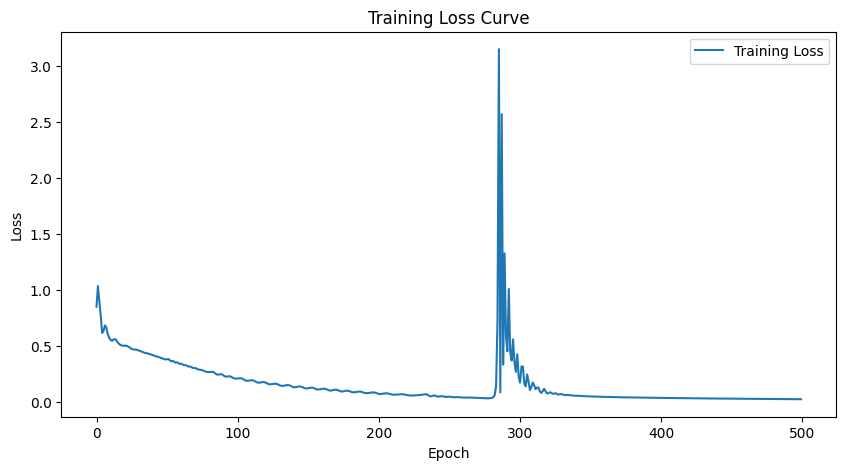

Final Model Accuracy: 75.00%


In [20]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [21]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE2_10.pth'.


In [22]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.70      0.91      0.79       194
non_infringement       0.86      0.59      0.70       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380



/tmp/ipykernel_3272563/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
